## Initial Version of the code

#### Todo:
    - Give some more values of Initial Values -> Done
    - Play With the Value of Alpha -> Done


In [1]:
#* Imports

import numpy as np 
import matplotlib.pyplot as plt #* For Plotting
import scipy as sp
from scipy import integrate #* For Solving Differential Equations
import snoop  #* For Debugging Purpose

from scipy.optimize import brentq 
from numbalsoda import lsoda_sig, lsoda,dop853 #Faster Method
import numba as nb #For Speeding Up
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline

In [2]:
#Parameters

mu=1.0 #! This Value was not given in paper. I solved it 
        #! using the constraint on the total energy
M=1.
L=1.
z0=0.5
alpha=0.01  #TODO Important Parameter. 

The Hamiltonian is : <br> <br>
$\mu*(pw^2/2\mu + pz^2/2\mu + L^2/(2 \mu^2 w^2) - M/\sqrt{w^2 + z^2} + \alpha z_0 \log(\cosh(z/z_0)))$

$L= p_{\phi} \;\;\;\;\;!$

In [3]:
@nb.njit
def logcosh(x):
    # s always has real part >= 0
    s = np.sign(x) * x
    p = np.exp(-2 * s)
    return s + np.log1p(p) - np.log(2)
@nb.njit
# @snoop
def H(mu: np.float64,ics: np.ndarray,alpha: np.int32) -> np.ndarray:
    """

    Args:
        mu (float): Mass of the Test Particle
        ics (np.ndarray): The Phase Space Coordinates of the particle
                        Shape(n,4)

    Returns:
        Energy of the particel (np.ndarray): Shape (n,)
    """
    if ics.ndim==1:
        w,z,phi,pw,pz,pphi=ics[0],ics[1],ics[2],ics[3],ics[4],ics[5]
    else:
        w,z,phi,pw,pz,pphi=ics[:,0],ics[:,1],ics[:,2],ics[:,3],ics[:,4],ics[:,5]
    L= pphi

    return mu*(pw**2/(2*mu) + pz**2/(2*mu) + L**2/(2* mu**2*w**2) - M/np.sqrt(w**2 + z**2) + alpha*z0*logcosh(z/z0))

In [4]:
ics=np.array([1.2,0.0,0.0,0.0,0.76,L]) #* Initial conditions w,z,phi, pw,pz,pphi from paper

In [5]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [6]:
t.shape

(100000,)

In [7]:
def evolve(t: float,x: np.ndarray,alpha: int)-> np.ndarray:
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    w,z,phi,pw,pz,pphi=x
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /(mu**2 * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0

    return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [8]:
# @nb.cfunc('')
def poincare(t: float,y: np.ndarray,args:np.int32)-> float:
    """Creating Poincare Section 

    Args:
        t (float): time Step
        y (np.ndarray): Shape (n,4)
        args (np.int32) : Not needed. But used for compatibility for
                            below methods

    Returns:
        float: The value where the function gets zero (z value in this case)
    """
    return y[1]


In [9]:
sol=integrate.solve_ivp(evolve,(0.,t[-1]),ics,'LSODA',t_eval=t,events=poincare,dense_output=True,args=(alpha,),atol=1e-11,rtol=1e-11)

In [10]:
cs= CubicSpline(sol.t,sol.y.T)

In [11]:
mask=sol.y_events[0][:,4]>0  #* Get those values where v_z is greater than zero

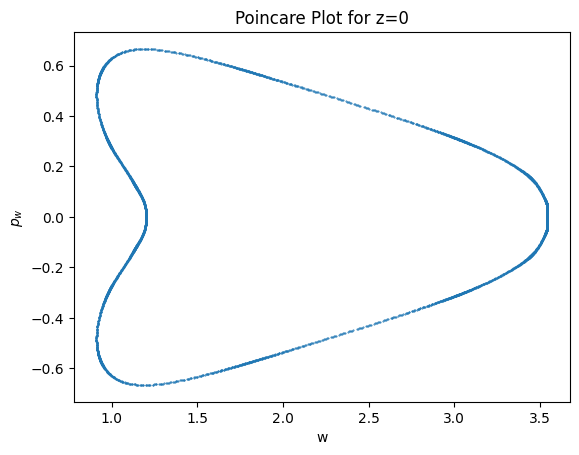

In [12]:

#* Poincare Plot
 
plt.scatter(sol.y_events[0][mask,0],sol.y_events[0][mask,3],s=0.2);
plt.title(r"Poincare Plot for z=0");
plt.xlabel(r"w");
plt.ylabel(r"$p_w$");

In [13]:
# plt.plot(sol.y[1])

In [15]:
energy=H(mu,sol.y.T,alpha=alpha) #Get the energy of given solutions

Text(0, 0.5, 'Energy')

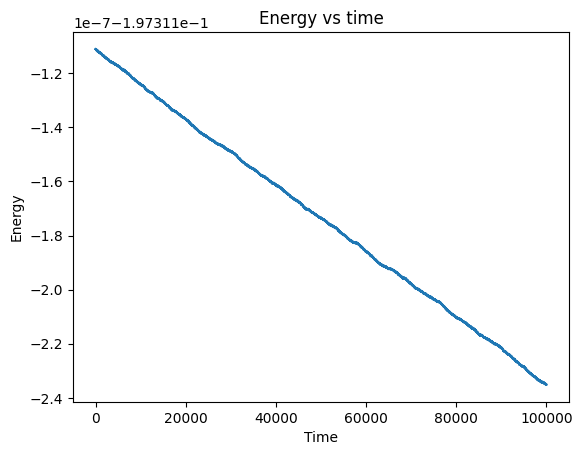

In [17]:
plt.plot(energy) 
plt.title("Energy vs time")
plt.xlabel("Time")
plt.ylabel("Energy")

#* The value of energy is within -0.2 (+/- 39e^(-8))

In [18]:
np.isclose(np.diff(energy),0).all()
#! All the values of energy are within 1e^(-8)

True

In [19]:

#! Faster Methods -----------------------------------

- <span style="color:red"> The following method generate the solutions very fast
 But it is very slow if you want to generate the Poincare
 Sections. We do not need this now. But I had put it for future reference </span>

##  <span style= "color:orange">Using LSODA wrapper </span>

In [20]:
#Faster Version of evolve method above
@nb.cfunc(lsoda_sig)
def faster_evolve(t,u, du,p):
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    # w,z, phi,pw,pz,pphi=x
    du[0]= u[3]
    du[1]= u[4]
    du[2]= L/(mu*u[0]**2)

    du[3]= -mu*(-L**2 /(mu**2 * u[0]**3) + M*u[0]/((u[0]**2+u[1]**2)**(3/2)))
    du[4]=-mu*(M*u[1]/((u[0]**2+u[1]**2)**(3/2))+ alpha*np.tanh(u[1]/z0))
    du[5]=0.0

    # return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [21]:
funcptr=faster_evolve.address

In [22]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]) #Initial conditions

In [23]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [24]:
n_events=6000

@nb.cfunc(lsoda_sig)
def poincare_event(t,u,out,p):
    for i in nb.prange(n_events):
        out[i]=u[1]

# jitted_events = nb.njit(poincare_event)
event_fcn=poincare_event.address

In [25]:
t_span=np.array([min(t),max(t)])

In [26]:
t_eval=np.arange(0,10000,1)

In [27]:
usol, success = lsoda(funcptr, u0, t,atol=1e-12,rtol=1e-12)

In [29]:
H(1.00,usol,alpha)

array([-0.19731111, -0.19731111, -0.19731111, ..., -0.19731113,
       -0.19731113, -0.19731113])

In [30]:
#Now, to make the poincare plot

#---------------Work in Progress------------------


In [31]:
idx2 = np.where(np.sign(usol[:,1][:-1]) != np.sign(usol[:,1][1:]))[0] + 1
idx1=idx2-1

In [32]:
# f=lambda t: lsoda(funcptr,u0 , np.array([0,t]), mxstep=5000000,atol=1e-10, rtol=1e-10)[0][-1,1];
# t_eval=np.zeros_like(idx1)

# for i in range(1,len(idx2)):
#     t_eval[i]=brentq(f,t[idx1[i]],t[idx2[i]])

# # t_eval=np.array(t_eval)

In [33]:
# plt.plot(t,H(mu,usol))

## <span style="color: magenta">Lyponov Exponents</span>

## What will we try

- The first step is to try the things as was done for Lorenz System
- We will copy the code with minor changes

- In the next step, we will use the same thing as above, only difference will be that it will be faster than above

In [34]:
#Step 1

In [56]:
#Using the method given in the paper

In [57]:
def chaotic_lyp(t,Y,alpha=alpha):
    """
    Function for solving the system of equation simultaneously with
    the Jacobian

    """

    #First system of equations
    
    w,z,phi,pw,pz,pphi=Y[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*(w**4))-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    #Now calculate the jacobian
    J=np.array([

        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    dY=Y[6:].reshape((6,1))
    dY_dt=np.dot(J,dY)

    return np.concatenate(([dw,dz,dphi,dpw,dpz,dpphi],dY_dt.flatten()))

In [58]:

#! Faster implementaton of above function
@nb.cfunc(lsoda_sig)
def faster_chaotic_system(t,u,du,p):
    """
    The same system as above but faster than above method. This uses Numba
    and Numbalsoda for faster evaluations
    """
    u_=nb.carray(u,(12,))
    p_=nb.carray(p,(1,))
    alpha=p_[0]
    w,z,phi,pw,pz,pphi=u_[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*w**4)-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    #Now calculate the jacobian

    J=np.array([
        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    dY=u_[6:].reshape((6,1))
    dY_dt=np.dot(J,dY)
    dydtf=dY_dt.flatten()
    du_=np.zeros((12,),dtype=nb.float64)
    du_[:6]=np.array([dw,dz,dphi,dpw,dpz,dpphi])
    du_[6:]=dydtf

    for i in range(len(du_)):
        du[i]=du_[i]



In [59]:
pfunctptr=faster_chaotic_system.address

In [60]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]) #Initial condition for x(0)
w0=np.random.normal(0.,1.,(6))
w0=w0/np.linalg.norm(w0) #Initial unitary deviation vector w(0)

In [61]:
ics0=np.array((u0,w0)).flatten() #Combined Initial vector

In [62]:
tau=1000  #Renormalization time
tf=1000000. #Final time

In [87]:

@nb.njit
def evolve_lyap(ics0,tau,tf,alpha,steps):

    ti=0.  #* Initial Time
    timestep=np.arange(ti,tf,tau) #* Time interval
    size=timestep.shape[0] 

    X1t=np.zeros((size-1)) #*Lyapunaov Exponents
    sum=0.0
    ics=ics0.copy()  #*We do not want to change our initial conditions
    h=np.zeros(size-1) #*Check for energy
    sol=np.zeros((size,6))
    sol[0,:]=ics[:6]

    for i in range(0,size-1):
        timeint=np.linspace(timestep[i],timestep[i+1],steps) #!Our time interval with 10000 points between them

        usol,_=lsoda(pfunctptr,ics,t_eval=timeint,data=np.array((alpha)),rtol=1e-12,atol=1e-12,mxstep=100000) #* Solver
        usol=usol[-1]

        #Uncomment following line to use scipy solver and comment above two lines
        # usol=integrate.solve_ivp(chaotic_lyp_paper,[0.,tf],ics0,'LSODA',t_eval=timeint,atol=1e-10,rtol=1e-10).y[:,-1] 
        
        xk=usol[:6]  #Orbit at t= tau
        wk=usol[6:]  #Deviations at t=tau

        #*---------------------The following algorithm is from the paper

        alphak=np.linalg.norm(wk) 
        sum=sum+np.log(alphak)
        X1t[i]=sum/timestep[i+1]
        wk0=wk/alphak

        #*----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:6]=xk
        ics[6:]=wk0

        #! ------------------------Sanity Check--------------------------
        h[i]=H(1.00,ics,alpha) #! Current Energy
        sol[i+1,:]=ics[:6]
        #! Comment above line if you do not want to perform the sanity check

    return X1t,h,sol


In [88]:
alpha=0.1 #*Current alpha

In [89]:
steps=10000 #*Number of time steps between each time interval 

In [90]:
_,energy_,sol_=evolve_lyap(ics0,tau,5000.,alpha,steps)  #!Run it for the first time so that numba understands the call signature

In [66]:
lyaps1=evolve_lyap(ics0,tau,tf,alpha,steps) #* Lyapunaov Exponents. 

#! If you get a warning the t+h_=t on the next step, ignore it.

lsoda -- warning..internal t = 570700 and h_ = 3.4508e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 570700 and h_ = 3.4508e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 570700 and h_ = 3.4508e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 570700 and h_ = 3.4508e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 582609 and h_ = 3.20063e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 582609 and h_ = 3.20063e-11 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..in

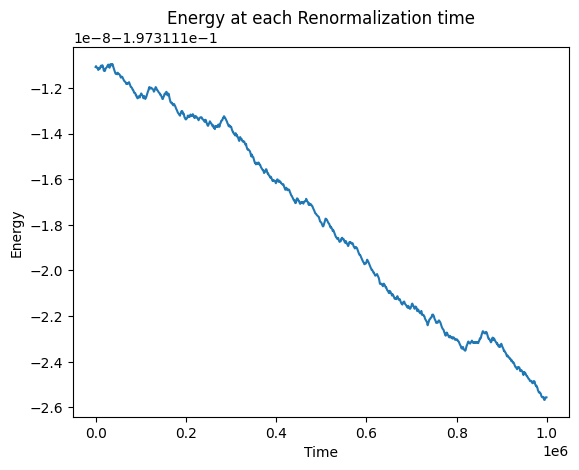

In [67]:
plt.plot(np.linspace(0.,tf,tau)[:-1],lyaps1[1]) #! Sanity check: Energy
plt.title("Energy at each Renormalization time")
plt.xlabel('Time');
plt.ylabel('Energy');

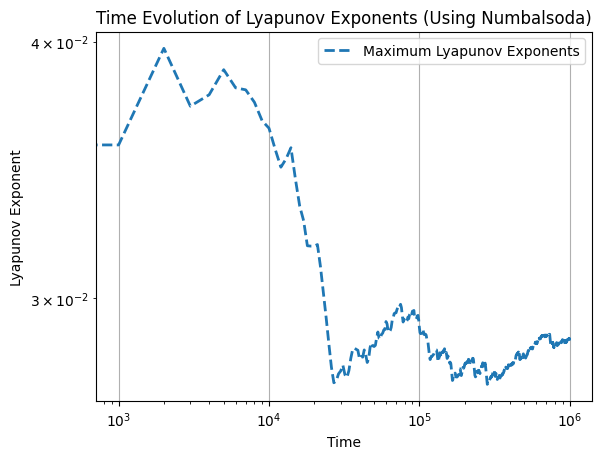

In [68]:
plt.figure()
plt.plot(np.arange(0.,tf,1000)[:-2],lyaps1[0][:-1],label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

In [69]:
alpha=0.01 #* Next case

In [70]:
lyaps2=evolve_lyap(ics0,tau,tf,alpha,steps)

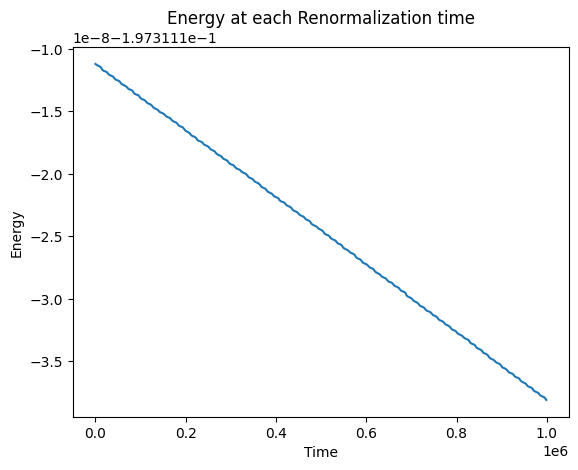

In [71]:
plt.plot(np.linspace(0.,tf,tau)[:-1],lyaps2[1]) #! Sanity check: Energy
plt.title("Energy at each Renormalization time")
plt.xlabel('Time');
plt.ylabel('Energy');

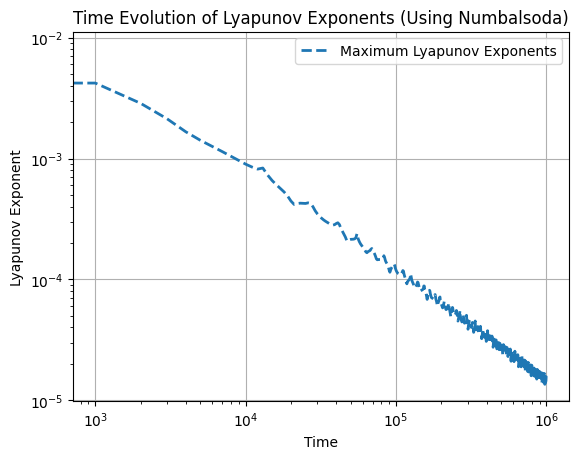

In [72]:
plt.figure()
plt.plot(np.arange(0.,tf,1000)[:-2],lyaps2[0][:-1],label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

In [73]:
alpha=10.

In [74]:
lyaps3=evolve_lyap(ics0,tau,tf,alpha,steps)

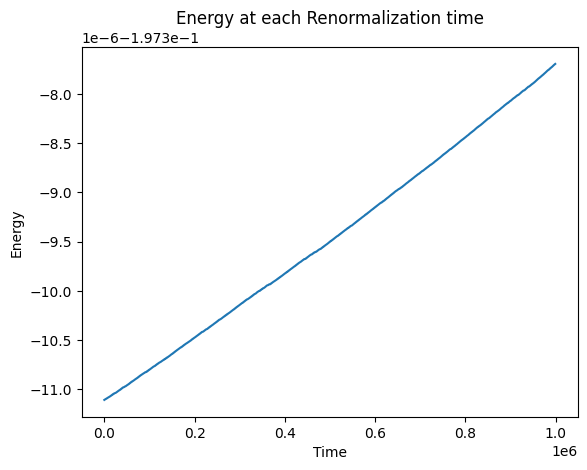

In [75]:
plt.plot(np.linspace(0.,tf,tau)[:-1],lyaps3[1])
plt.title("Energy at each Renormalization time")
plt.xlabel('Time');
plt.ylabel('Energy');

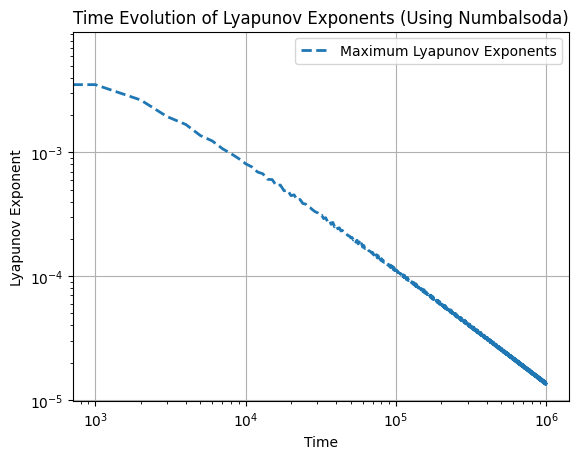

In [76]:
plt.figure()
plt.plot(np.arange(0.,tf,1000)[:-2],lyaps3[0][:-1],label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

In [79]:
#!Sanity Checks

In [126]:
alpha=0.1

#!Time step is 1000/(sti) where sti is one of the below.
#!Eg: If sti=10000, time step is 1000/10000=0.1 and so on
st1=10000
st2=50000
st3=100000

In [92]:

#! For the sanity check, we want only the solutions
_,_,sol1=evolve_lyap(ics0,tau,tf,alpha,st1)
_,_,sol2=evolve_lyap(ics0,tau,tf,alpha,st2)
_,_,sol3=evolve_lyap(ics0,tau,tf,alpha,st3)

lsoda -- warning..internal t = 531897 and h_ = 2.37589e-12 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 531897 and h_ = 2.37589e-12 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 531897 and h_ = 2.37589e-12 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 531897 and h_ = 2.37589e-12 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 531897 and h_ = 4.75178e-12 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning..internal t = 531897 and h_ = 4.75178e-12 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.
lsoda -- warning

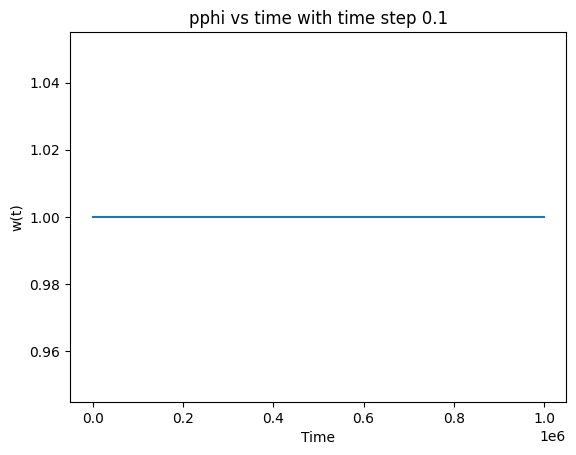

In [123]:
plt.plot(np.arange(0.,tf,1000),sol1[:,-1]);
plt.title("pphi vs time with time step 0.1")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig10000.png')

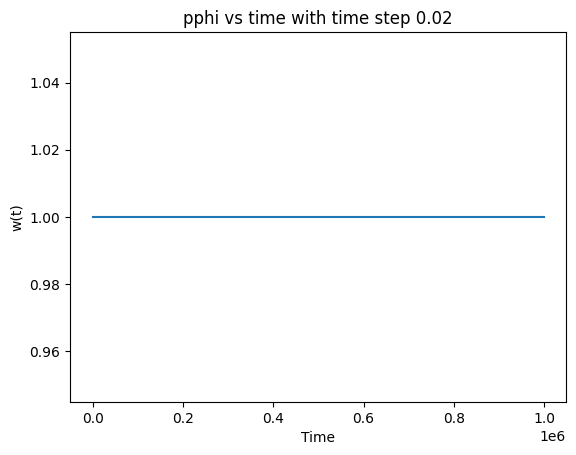

In [124]:
plt.plot(np.arange(0.,tf,1000),sol2[:,-1]);
plt.title("pphi vs time with time step 0.02")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig50000.png')

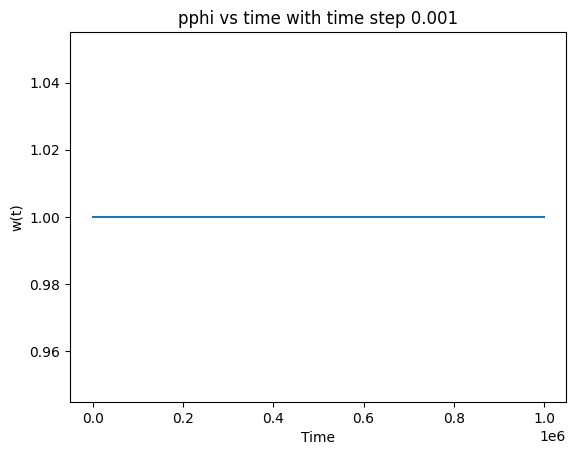

In [125]:
plt.plot(np.arange(0.,tf,1000),sol3[:,-1]);
plt.title("pphi vs time with time step 0.001")
plt.xlabel('Time')
plt.ylabel('w(t)');
plt.savefig('fig100000.png')